# Propósito

Realizar a limpeza do conjunto de dados
### Passo a passo: 
- Tamanho da base;
- Análise de inconsistências;
- Análise de dados faltosos.
- Remover duplicatas
- Revmoa
- Rkadad


Autora: Grazielly de Melo Oliveira. 

## Dependências

In [1]:
#Importando bibliotecas
import os
import cloudpickle
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils.data_cleaning import remover_duplicatas,remover_colunas_constantes,normalizar_caracteres
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


## Dados e Constantes

In [42]:

# Constantes
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_INTER_PATH = os.path.join('..','data','inter')
RAW_INPUT_DATA = 'diabetes_data.csv'
TRAIN_DATA = 'diabetes_train.parquet'
TEST_DATA = 'diabetes_test.parquet'
# Dados
df_raw = pd.read_csv(os.path.join(DATA_RAW_PATH, RAW_INPUT_DATA))

In [43]:
# Colunas do dataframe
df_raw.columns

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching', 'Irritability', 'delayed healing', 'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class'], dtype='object')

In [44]:
print(f'Shape do dataset: {df_raw.shape}')

Shape do dataset: (520, 17)


# Limpeza

## Renomando Colunas

In [45]:
#Renomeando colunas
# idealmente deveria ser um step do pipeline de pre-processamento quando em produção
def renomear_colunas(df):
    df.rename(columns={'Age': 'idade','Gender':'genero','Polyuria':'polyuria',
                        'Polydipsia':'polydipsia','sudden weight loss':'perda_de_peso_repentina',
                            'weakness':'fraqueza','Polyphagia':'polyphagia',
                            'Genital thrush':'candidiase_genital',
                            'visual blurring':'desfoque_visual','Itching':'coceira',
                            'Irritability':'irritabilidade',
                            'delayed healing':'cicatrizacao_retardada',
                            'partial paresis':'paresia_parcial',
                            'muscle stiffness':'rigidez_muscular','Alopecia':'alopecia',
                            'Obesity':'obesidade','class':'target'},inplace=True)
    return df

In [46]:
df_raw = renomear_colunas(df_raw)
df_raw.reset_index(drop=True,inplace=True)

In [47]:
df_raw.shape

(520, 17)

# Duplicatas

Antes de dividirmos em treino e teste, vamos checar se existem colunas e linhas duplicatas.

In [48]:
#Observando e removendo duplicatas nas linhas e colunas. 
lista_colunas_removidas = remover_duplicatas(df_raw, drop_if_found=False)

Existem 0 colunas duplicadas e 269 linhas duplicadas


Existem 269 linhas duplicadas no dataset. Aqui assumimos duas hipóteses possíves:
1) São os mesmos pacientes repetidos
2) Não são pacientes repetidos, mas o quadro clínico é igual

Na hipótese 1, droparíamos as linhas duplicadas, pois isso afetaria as distribuições de forma errada.

Na hipótese 2, podemos utilizar o dataset, tendo cuidado com as métricas obtidas, pois elas podem conter viéses otimistas ou pessimistas, dependendo de como o modelo performa nessas instâncias repetidas.
Caso a instância duplicada seja classificada errada, isso pode gerar um viés negativo na métrica de performance. Por sua vez, caso a instância repetida seja classificada corretamente, isso pode gerar um viés otimista para as métricas.map

Seguiremos da seguinte forma:
Manteremos as duplicatas no dataset de treino e teste (caso ocorra) e avaliaremos o modelo com e sem elas, para observar o que acontece.

# Tipagem 

Vamos chegar se existe alguma variável com o tipo não consistente.

In [49]:
df_raw.dtypes

idade                       int64
genero                     object
polyuria                   object
polydipsia                 object
perda_de_peso_repentina    object
fraqueza                   object
polyphagia                 object
candidiase_genital         object
desfoque_visual            object
coceira                    object
irritabilidade             object
cicatrizacao_retardada     object
paresia_parcial            object
rigidez_muscular           object
alopecia                   object
obesidade                  object
target                     object
dtype: object

A variável idade deveria ser inteiro, vamos converter.

In [50]:
df_raw['idade'] = df_raw['idade'].astype('int')
df_raw['target'] = df_raw['target'].map({'Positive':1, 'Negative':0})

In [51]:
df_raw.corr()

,idade,target
idade,1.000000,0.108679
target,0.108679,1.000000


In [52]:
df_raw.shape

(520, 17)

Idealmente isso também seria um step do pipeline de transformação. Para simplificar, vamos manter os tipos já convertidos e prosseguir, considerando que isso seria resolvido pelo time de engenharia de dados.

# Split dos dados em treino e teste

Usaremos 20% dos dados para treino e faremos isso de forma estratificada, para garantir mesma proporção das classes em cada dataset gerado.

In [53]:
#Separando os dados. 
X = df_raw.drop('target', axis=1)
y = df_raw['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3,  stratify= y, random_state=123)
#Dados de treino e de teste
df_train = pd.concat([X_train,y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


In [54]:
df_train.duplicated(keep=False).sum()

232

In [55]:
df_test.duplicated(keep=False).sum()

81

In [56]:
df_test.shape

(156, 17)

In [57]:
# salvando os dados de teste
df_test.to_parquet(os.path.join(DATA_INTER_PATH, TEST_DATA), index=False)
del df_test

Daqui em diante só analisaremos os dados de treino

In [58]:
# Lista de variáveis categóricas
lista_variaveis_categoricas = set(df_train.select_dtypes(include=['object']).columns.tolist())

# Normalização das classes

Vimos que alguns caracteres estão maísculos. Como não sabemos se é um padrão, vamos converter todo caractere para minúsculo. 

In [59]:
# Normalizando os caracteres (precisaremos incluir isto em um pipeline depois)
df_train = normalizar_caracteres(lista_variaveis_categoricas, df_train)

# Inconsistências nas colunas

Vamos checar as classes presentes em cada coluna e ver se existe algum erro de formatação.

In [60]:
# # Verificando inconsistência nas colunas.
for var_cat in lista_variaveis_categoricas:
    resul = df_train[var_cat].value_counts()
    print(resul)
    print("\n")

no     299
yes     65
Name: obesidade, dtype: int64


no     195
yes    169
Name: polydipsia, dtype: int64


male      229
female    135
Name: genero, dtype: int64


no     251
yes    113
Name: alopecia, dtype: int64


yes    187
no     177
Name: polyuria, dtype: int64


no     222
yes    142
Name: rigidez_muscular, dtype: int64


no     198
yes    166
Name: desfoque_visual, dtype: int64


no     211
yes    153
Name: perda_de_peso_repentina, dtype: int64


no     192
yes    172
Name: coceira, dtype: int64


no     283
yes     81
Name: candidiase_genital, dtype: int64


no     279
yes     85
Name: irritabilidade, dtype: int64


no     198
yes    166
Name: cicatrizacao_retardada, dtype: int64


no     201
yes    163
Name: paresia_parcial, dtype: int64


no     195
yes    169
Name: polyphagia, dtype: int64


yes    217
no     147
Name: fraqueza, dtype: int64




Aparentemente as strings seguem o padrão de yes ou no e nenhuma outra classe, a não ser female ou male, aparece no dataset.

# Missing Values

Sabemos que os valores faltosos podem se apresentar de diversas formas. Já vimos que nosso dataset só contém yes ou no, porém, por desencardo de consciência vamos normalizar representações de missing values, a fim de identificá-los mais para frente.

In [61]:
#Convertendo valores faltosos para np.nan
df_train.replace([None, 'Null', 'null','NULL', -np.inf, np.inf, -999, '-999', '-1',-1, ''], np.nan,inplace=True)

Precisaremos garantir em produção que também haverá essa preocupação

In [62]:
#Observando a porcentagem dos valores faltosos.
porcentagem_de_missings = round(df_train.isna().sum()/df_raw.shape[0]*100,1)
porcentagem_de_missings.sort_values(ascending=False)

idade                      0.0
coceira                    0.0
obesidade                  0.0
alopecia                   0.0
rigidez_muscular           0.0
paresia_parcial            0.0
cicatrizacao_retardada     0.0
irritabilidade             0.0
desfoque_visual            0.0
genero                     0.0
candidiase_genital         0.0
polyphagia                 0.0
fraqueza                   0.0
perda_de_peso_repentina    0.0
polydipsia                 0.0
polyuria                   0.0
target                     0.0
dtype: float64

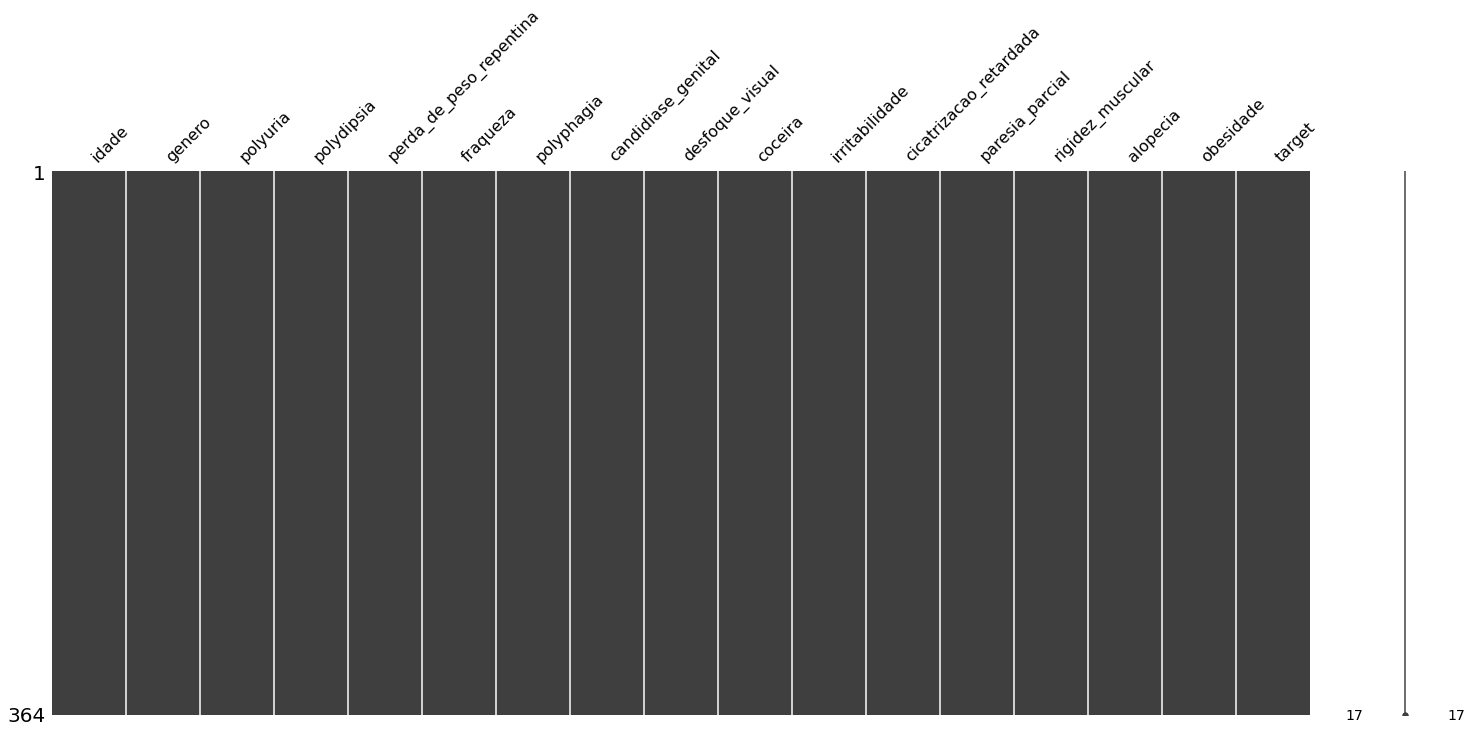

In [63]:
#Plotando a matrix para uma melhor visualização.
msno.matrix(df_train)
plt.show()

Não há missings. Mas, não há nada que nos garanta que após a atualização de base as colunas venham completas. Tentaremos achar uma padrão para inputar os null mais a frente. Na etapa de modelagem criaremos um Pipeline afim de preenchê-los da melhor forma possível.


# Colunas Constantes

Colunas constantes não adicionam valor à modelagem e à análise.

In [64]:
#Analisando se há colunas constantes para dropar. 
df_train, const_cols = remover_colunas_constantes(df_train)

In [68]:
df_train.head()

,idade,genero,polyuria,polydipsia,perda_de_peso_repentina,fraqueza,polyphagia,candidiase_genital,desfoque_visual,coceira,irritabilidade,cicatrizacao_retardada,paresia_parcial,rigidez_muscular,alopecia,obesidade,target
252,39,female,yes,yes,yes,yes,yes,no,no,yes,yes,yes,yes,no,no,no,1
513,62,female,yes,yes,yes,yes,no,no,yes,no,no,no,yes,no,no,yes,1
401,36,male,no,no,no,no,no,no,no,no,no,no,no,no,no,no,0
276,30,male,no,no,no,no,no,no,no,no,no,no,no,no,no,no,0
73,38,female,yes,yes,yes,yes,yes,no,no,no,no,no,yes,no,no,no,1


# Exportando dados e dicionário de dados


Estamos exportando tudo para parquet, para que os tipos sejam mantidos.

In [66]:
df_train.to_parquet(os.path.join(DATA_INTER_PATH,TRAIN_DATA), index=False)